In [17]:
import numpy as np
from scipy.linalg import cholesky
from scipy.special import erf

def MKF(Y, F, G, H, Q, R, Pi_0, hat_x_0, k, epsilon, gamma_2):
    N = Y.shape[1]
    P = Pi_0
    X = hat_x_0
    hat_X = []

    for i in range(N):
        X = F @ X
        
        M = F @ P @ F.T + G @ Q @ G.T
        
        Sigma_x = gamma_2 * M
        Sigma_v = gamma_2 * R
        
        S = H @ Sigma_x @ H.T + Sigma_v
        S_square = cholesky(np.linalg.inv(S)).T
        
        
        
        X = X + Sigma_x @ H.T.reshape(-1,1) @ S_square @ phi(S_square @ (Y[:, i] - H @ X), k)
        
        hat_X.append(X)
        
        P = Sigma_x - Sigma_x @ H.T.reshape(-1,1) @ np.linalg.inv(S) @ H.reshape(1,2) @ Sigma_x * (1 - epsilon) * (1 - 2 * Phi(-k))
    
    hat_X = np.array(hat_X).T
    return hat_X, P

def phi(normalized_innovation, k):
    value = np.copy(normalized_innovation)
    value[normalized_innovation < -k] = -k
    value[normalized_innovation > k] = k
    #Boolean_Indexing:-Will create boolean array and pick index of value where boolean array is true
    return value

def Phi(x):
    return 0.5 * (1 + erf(x / np.sqrt(2)))

In [18]:
import numpy as np

def TMKF(Y, real_F, G, H, Q, R, Pi_0, hat_x_0):
    N = Y.shape[1]
    P = Pi_0
    X = hat_x_0
    n = len(hat_x_0)
    hat_X = []

    for i in range(N):
        F = real_F[i]
        X = np.dot(F, X)
        Z_ = np.dot(H, X)

        P = np.dot(F, np.dot(P, F.T)) + np.dot(G, np.dot(Q, G.T))
        
        K = np.dot(P, np.dot((H.T).reshape(2,1), np.linalg.inv(np.dot(H, np.dot(P, H.T)) + R)))
        X = X + np.dot(K, (Y[:, i] - Z_))
        if len(hat_X) == 0:
            hat_X = np.array(X).reshape(-1, 1)
        else:
            hat_X = np.hstack((hat_X, X.reshape(-1, 1)))
        
        I = np.eye(n)
        P = np.dot(I - np.dot(K,H.reshape(1,2)), np.dot(P,(I-np.dot(K,H.reshape(1,2))).T)) +np.dot(K,np.dot(R,K.T))

   
    
    return hat_X, P

In [19]:
import numpy as np

def KF(Y, F, G, H, Q, R, Pi_0, hat_x_0):
    _, N = Y.shape
    P = Pi_0
    X = hat_x_0
    n = len(hat_x_0)
    hat_X = []

    for i in range(N):
        # Predict step
        X = F @ X
        Z_ = H @ X

        P = F @ P @ F.T + G @ Q @ G.T

        # Update step
        S = H @ P @ H.T + R

        K = (P @ H.T).reshape(-1,1) @ np.linalg.inv(S)
        X = X + K @ (Y[:, i] - Z_)

        hat_X.append(X)

        # Covariance update
        P = P - (P @ H.T).reshape(-1,1) @ np.linalg.inv(S) @ ((H @ P).reshape(1,2))

    hat_X = np.array(hat_X).T
    return hat_X, P

In [20]:
import numpy as np
from scipy.linalg import cholesky
from scipy.special import erf

def Huber(Y, F, G, H, Q, R, Pi_0, hat_x_0, k, epsilon):
    _, N = Y.shape
    P = Pi_0
    X = hat_x_0
    n = len(hat_x_0)
    hat_X = []

    for i in range(N):
        X = F @ X
        Z_ = H @ X

        P = F @ P @ F.T + G @ Q @ G.T

        S = H @ P @ H.T + R
        S_square = cholesky(np.linalg.inv(S)).T  
        
        
        X = X + P @ (H.T.reshape(2,1)) @ S_square @ phi((S_square @ (Y[:, i] - Z_)), k)
        hat_X.append(X)
        
        P = P - (P @ (H.T).reshape(2,1))@ np.linalg.inv(S) @ (H.reshape(1,2)) @P *(1 - epsilon) * (1 - 2 * Phi(-k))
    
    hat_X = np.array(hat_X).T
    return hat_X, P

def phi(normalized_innovation, k):
    value = np.copy(normalized_innovation)
    value[normalized_innovation < -k] = -k
    value[normalized_innovation > k] = k
    return value

def Phi(x):
    return 0.5 * (1 + erf(x / np.sqrt(2)))


In [21]:
import numpy as np
from scipy.sparse.linalg import eigs

def WKF(sys, rho, Y_T, x_0, V_0, opts=None):
    """
    Wasserstein Kalman filter - Python implementation of Algorithm 3

    Args:
    sys:  A dictionary containing the linear system model
        sys['A']: Matrix A_t in state-space representation
                  sys['A'] should be a numpy array of shape (n, n) or
                  a list of length T with elements of shape (n, n)
        sys['B']: Matrix B_t in state-space representation
                  sys['B'] should be a numpy array of shape (n, d) or
                  a list of length T with elements of shape (n, d)
        sys['C']: Matrix C_t in state-space representation
                  sys['C'] should be a numpy array of shape (m, n) or
                  a list of length T with elements of shape (m, n)
        sys['D']: Matrix D_t in state-space representation
                  sys['D'] should be a numpy array of shape (m, d) or
                  a list of length T with elements of shape (m, d)
    rho:  A scalar or a numpy array of length T whose t-th element is the Wasserstein ambiguity size at time t
    Y_T:  A numpy array of shape (m, T) whose t-th column is the observed output at time t
    x_0:  Initial point estimate
    V_0:  Initial covariance estimate
    opts: A dictionary containing the parameters for Frank-Wolfe algorithm

    Returns:
    xhat: A numpy array of shape (n, T) whose t-th column is the estimated state at time t
    V:    A numpy array of shape (n, n, T) whose t-th block is the estimated conditional covariance at time t
    G:    A numpy array of shape (n, m, T) whose t-th block is the WKF gain at time t
    S:    A numpy array of shape (d, d, T) whose t-th block is the least favorable covariance matrix at time t
    """

    if opts is None:
        opts = {}

    T = Y_T.shape[1]
    n = sys['F'].shape[0]
    m = sys['H'].shape[0]
    d = n + m

    x_prev = x_0
    V_prev = V_0
    xhat = np.zeros((n, T))
    V = np.zeros((n, n, T))
    G = np.zeros((n, m, T))
    S = np.zeros((d, d, T))
    for t in range(T):
        mu_t, Sigma_t = predict(x_prev, V_prev, sys)
        rho_t = rho

        xhat[:, t], V[:, :, t] = update(mu_t, Sigma_t, rho_t, Y_T[:, t], len(x_0), opts)

        x_prev = xhat[:, t]
        V_prev = V[:, :, t]

    return xhat, V, G, S

def predict(x_prev, V_prev, sys):
    A_aug = np.vstack((sys['F'], np.dot(sys['H'], sys['F'])))
    B_aug = np.block([
    [np.dot(sys['G'], np.dot(sys['Q'], sys['G'].T)), (np.dot(np.dot(sys['G'], sys['Q']), np.dot(sys['G'].T, sys['H'].T))).reshape(-1,1)],
    [(np.dot(np.dot(sys['H'], sys['G']), np.dot(sys['Q'], sys['G'].T))), np.dot(np.dot(np.dot(sys['H'], sys['G']), np.dot(sys['Q'], sys['G'].T)), sys['H'].T) + sys['R']]
    ])
    
    mu_t = np.dot(A_aug, x_prev)
    Sigma_t = np.dot(np.dot(A_aug, V_prev), A_aug.T) + B_aug

    return mu_t, Sigma_t

def update(mu_t, Sigma_t, rho_t, y_t, x_dim, opts):
    phi_star, Q_star,_,_ = FrankWolfe(mu_t, Sigma_t, rho_t, x_dim, opts)
    G_t = phi_star['G']
    S_t = Q_star['Sigma']
    V_t = S_t[:x_dim, :x_dim] - np.dot(G_t, S_t[x_dim:, :x_dim])
    xhat_t = np.dot(G_t, (y_t - mu_t[x_dim:])) + mu_t[:x_dim]

    return xhat_t, V_t

def FrankWolfe(mu_t, Sigma_t, rho_t, x_dim, opts):
   
    """
    Frank-Wolfe algorithm - Python implementation of Algorithm 2

    Args:
    mu: Mean vector of the prior distribution
    Sigma: Covariance matrix of the prior distribution
    rho: Wasserstein ambiguity size
    x_dim: Dimension of the unobserved random variable x
    opts: Dictionary containing the parameters for Frank-Wolfe algorithm
        opts['iter_max']: Maximum number of iterations (default: 1000)
        opts['bi_tol']: Bisection tolerance value (default: 1e-8)
        opts['tol']: Relative duality gap as stopping criteria (default: 1e-4)
        opts['verbose']: Set to True to turn on verbose output (default: False)

    Returns:
    phi_star: Dictionary containing parameters of the optimal affine decision rule
        phi_star['G']: Slope of the optimal decision rule
        phi_star['g']: Intercept of the optimal decision rule
    Q_star: Dictionary containing parameters of the least favorable prior
        Q_star['mu']: Mean vector of the least favorable prior
        Q_star['Sigma']: Covariance matrix of the least favorable prior
    obj: Stored objective value in any iterations of Frank-Wolfe algorithm
    res: Stored dual optimality gap in any iterations of Frank-Wolfe algorithm
    """
    
    # Default parameters
    if opts is None:
        opts = {}
    iter_max = opts.get('iter_max', 1000)
    bi_tol = opts.get('bi_tol', 1e-8)
    tol = opts.get('tol', 1e-4)
    verbose = opts.get('verbose', False)
    
    # Auxilary functions
    def G_(S):
        return S[:n, n:] @ np.linalg.inv(S[n:, n:])
    
    def f_(S, G):
        return np.trace(S[:n, :n] - G @ S[n:, :n])
    
    def grad_f_(G):
        return np.block([[np.eye(n), -G]]).T @ np.block([[np.eye(n), -G]])
    
    def vec(x):
        return x.flatten()

    # Initialize    
    S = Sigma_t.copy()
    obj = np.zeros(iter_max)
    res = np.zeros(iter_max)
    
    n = x_dim

    # Return Bayes estimator if rho is zero
    if rho == 0:
        G = G_(Sigma)
        phi_star = {'G': G, 'g': mu_t[:n] - G @ mu_t[n:]}
        Q_star = {'Sigma': Sigma, 'mu': mu_t}
        return phi_star, Q_star, obj, res

    # Print the caption
    if verbose:
        print(f"{' ' * 22}\nFrank-Wolfe's method \n{' ' * 22}\n  Iter|  Objective \n{' ' * 22}")


    # The main loop
    for iter in range(iter_max):

        # Printing the objective values
        G = G_(S)
        obj_current = f_(S, G)
        if iter % (iter_max // 10) == 0 and verbose:  
            print(f"{iter:6d}| {obj_current:5.4e}")

        # Computing partial derivitive & solve the algebraic equation
        D = grad_f_(G)
        L = my_bisection(Sigma_t, D, rho, bi_tol)

        # Check the optimality condition
        res_current = abs(vec(L-S).T @ vec(D))
        if res_current / obj_current < tol:
            break

        # Updating the current solution
        alpha = 2 / (2 + iter)
        S = (1 - alpha) * S + alpha * L
        
        # Store results
        if iter > 0:
            obj[iter] = obj_current
            res[iter] = res_current

    if iter < iter_max:
        obj = obj[:iter]
        res = res[:iter]

    phi_star = {'G': G, 'g': mu_t[:n] - G @ mu_t[n:]}
    Q_star = {'Sigma': S, 'mu': mu_t}

    return phi_star, Q_star, obj, res

def my_bisection(Sigma, D, rho, bi_tol):
   

    d = D.shape[0]

    # Auxilary functions
    def h(inv_D):
        return rho*2 - np.sum(Sigma * (np.eye(d) - inv_D)*2)
    
    def vec(x):
        return x.flatten()

    # Finding the bisection intervals
    
    lambda_1, v_1 = eigs(D, k=1)
    LB = lambda_1[0] * (1 + np.sqrt(v_1[:,0].T @ Sigma @ v_1[:,0]) / rho)
    UB = lambda_1[0] * (1 + np.sqrt(np.trace(Sigma)) / rho)

    # The main loop
    while True:
        gamma = (LB + UB) / 2

        D_inv = gamma * np.linalg.inv(gamma * np.eye(d) - D)
        L = D_inv @ Sigma @ D_inv
        h_val = h(D_inv)

        if h_val < 0:
            LB = gamma
        else:
            UB = gamma

        Delta = gamma * (rho**2 - np.trace(Sigma)) + gamma * vec(D_inv).T @ vec(Sigma) - vec(L).T @ vec(D)

        if (h_val >= 0) and (Delta < bi_tol):
            break

    return L

In [22]:
import numpy as np
from scipy.linalg import solve_discrete_are, expm, cholesky
from control import ctrb
from scipy.linalg import cho_factor
from scipy.linalg import eigh

def tauKF(sys, c, tau, y, x_0, V_0):
    sh = sys['H'].shape
    if len(sh) == 1:
        a = 1
        b = sh[0]
    else:
        a, b = sys['H'].shape
    A = sys['F']
    B = np.hstack([sys['G'] @ sys['Q'] @ sys['G'].T, np.zeros((b, a))])
    C = np.array([sys['H']])
    D = np.hstack([np.zeros((a, b)), sys['D'] @ sys['R'] @ sys['D'].T])
    n = A.shape[0]
    p = a  #C.shape[0]
    m = B.shape[1]
    T = y.shape[0]
    A = A - B @ D.T@ np.linalg.inv(D @ D.T) @ C.reshape(1,2)
    B = np.hstack([(B @ (np.eye(m) - D.T @ np.linalg.inv(D @ D.T) @ D) @ B.T)**0.5, np.zeros((n, m - n))])
    D = np.hstack([np.zeros((p, n)), (D @ D.T)**0.5])
    Q = B @ B.T
    R = D @ D.T
    
    assert c > 0, 'Tolerance c must be positive'
    assert np.linalg.matrix_rank(ctrb(A, Q)) >= n, 'The model must be reachable'
    assert np.linalg.matrix_rank(ctrb(A.T, C.T)) >= n, 'The model must be observable'
    cN = maxtol(A, B, C, D, tau, 2 * n)

    x = np.zeros((T, n))
    V = np.zeros((n, n, T + 1))
    P = np.zeros((n, n, T + 1))
    G = np.zeros((n, p, T + 1))
    th = np.zeros((T, 1))
    x[0, :] = x_0
    V[:, :, 0] = V_0

    for k in range(T-1):
        x[k + 1, :], V[:, :, k + 1], G[:, :, k + 1], P[:, :, k + 1], th[k] = rkiteration(A, B, C, D, V[:, :, k], tau, c, x[k, :], y[k, :])

    #x = x[1:T + 1, :]
    P = P[:, :, 1:T + 1]
    V = V[:, :, 1:T + 1]
    G = G[:, :, 1:T + 1]

    return x, G, V, P, th

def maxtol(A, B, C, D, tau, N=None):
    n = A.shape[0]
    sh = sys['H'].shape
    if len(sh) == 1:
        a = 1
        b = sh[0]
    else:
        a, b = sys['H'].shape
    if N is None:
        N = 2 * n

    m = B.shape[1]
    p = a #C.shape[0]

    
    DR = np.kron(np.eye(N), D)
    Re = []
    Ob = []
    ObR = []
    H = []
    L = []
    
    for k in range(1, N + 1):
        Re.append(A**(k - 1) @ B)
        Ob.insert(0, C @ A**(k - 1))
        ObR.insert(0, A**(k - 1))
        T = []
        for l in range(1, N + 1):
            if l <= N - (k - 1):
                T.append(np.zeros((p, m)))
            else:
                #print((A**(l - N + (k - 1) - 1)).shape)
                T.append((C @ A**(l - N + (k - 1) - 1) @ B).reshape(1,-1))
               
        
        H.insert(0, np.hstack(T))
        T = []
        for l in range(1, N + 1):
            if l <= N - (k - 1):
                T.append(np.zeros((n, m)))
            else:
                T.append(A**(l - N + (k - 1) - 1) @ B)
        L.insert(0, np.hstack(T))
    
    #Re = np.hstack(Re)
    Ob = np.vstack(Ob)
    #ObR = np.vstack(ObR)
    #H = np.vstack(H)
    #L = np.vstack(L)
    
    Om = Ob.T @ np.linalg.inv(DR @ DR.T + H @ H.T) @ Ob
    J = ObR - L @ H.T @ np.linalg.inv(DR @ DR.T + H @ H.T) @ Ob
    M = L @ np.linalg.inv(np.eye(N * m) + H.T @ np.linalg.inv(DR @ DR.T) @ H) @ L.T

    phiNtilde = 1 / max(np.linalg.eigvals(M))

    value = 1
    t1 = 0
    t2 = (1 - 1e-10) * phiNtilde
    while abs(value) >= 1e-9:
        theta = 0.5 * (t1 + t2)
        Sth = -np.eye(N * n) + theta * M
        Omth = Om + J.T @ (theta * np.linalg.inv(Sth)) @ J
        value = -min(np.linalg.eigvals(Omth))
        if value > 0:
            t2 = theta
        else:
            t1 = theta

    phiN = min(phiNtilde, theta)
    Pq = solve_discrete_are(A.T, C.T, B @ B.T, D @ D.T)
    lambda_min = min(np.linalg.eigvals(Pq))

    if tau == 1:
        thN = -np.log(1 - phiN * lambda_min) / lambda_min
    else:
        thN = (1 - ((1 - lambda_min * phiN)**(1 - tau))) / ((1 - tau) * lambda_min)

    if 0 <= tau < 1:
        thNmax = ((1 - tau) * max(np.linalg.eigvals(Pq)))-1
    else:
        thNmax = np.inf

    if thN >= thNmax:
        cN = np.inf
    else:
        if tau == 0:
            cN = (np.log(np.linalg.det(np.eye(n) - thN * Pq)) + np.trace(np.linalg.inv(np.eye(n) - thN * Pq)) - n)
        if 0 < tau < 1:
            Lq = cholesky(Pq, lower=True)
            cN = np.trace(-1 / (tau * (1 - tau)) * (np.eye(n) - thN * (1 - tau) * Lq.T @ Lq)(tau / (tau - 1)) + 1 / (1 - tau) * (np.eye(n) - thN * (1 - tau) * Lq.T @ Lq)(1 / (tau - 1)) + 1 / tau * np.eye(n))
        if tau == 1:
            Lq = cholesky(Pq, lower=True)
            cN = np.trace(expm(thN * Lq.T @ Lq) * (thN * Lq.T @ Lq - np.eye(n)) + np.eye(n))
    
    return cN

def rkiteration(A, B, C, D, V, tau, c, x, y):
    n = A.shape[0]
    p = C.shape[0]
    m = B.shape[1]

    Q = B @ B.T
    R = D @ D.T

    G = A @ V @ C.T @ np.linalg.inv(C @ V @ C.T + R)
    x_pred = (A @ x.T + G @ (y - C @ x.T)).T
    P = (A - G @ C) @ V @ (A - G @ C).T + (B - G @ D) @ (B - G @ D).T
    P = nearest_positive_definite(P)
    L = np.linalg.cholesky(P).T

    value = 1
    t1 = 0
    if tau == 1:
        t2 = 10 / max(np.linalg.eigvals(P))
    else:
        e = np.linalg.eigvals(P)
        r = max(abs(e))
        t2 = (1 - 1e-5) * ((1 - tau) * r)-1

    while abs(value) >= 1e-9:
        th = 0.5 * (t1 + t2)
        if tau == 0:
            value = np.trace(np.linalg.inv(np.eye(n) - th * P) - np.eye(n)) + np.log(np.linalg.det(np.eye(n) - th * P)) - c
        if 0 < tau < 1:
            value = np.trace(-1 / (tau * (1 - tau)) * (np.eye(n) - (1 - tau) * th * L.T @ L)(tau / (tau - 1)) + 1 / (1 - tau) * (np.eye(n) - (1 - tau) * th * L.T @ L)(1 / (tau - 1)) + 1 / tau * np.eye(n)) - c
        if tau == 1:
            value = np.trace(th * L.T @ L @ expm(th * L.T @ L) - expm(th * L.T @ L) + np.eye(n)) - c
        if value > 0:
            t2 = th
        else:
            t1 = th

    Vold = V
    if tau == 1:
        V = L @ expm(th * L.T @ L) @ L.T
    else:
        V = L @ ((np.eye(n) - (1 - tau) * th * L.T @ L)**(1 / (tau - 1))) @ L.T

    return x_pred, V, G, P, th
def nearest_positive_definite(A):
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    H = np.dot(V.T, np.dot(np.diag(s), V))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    if is_positive_definite(A3):
        return A3
    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not is_positive_definite(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    return A3

def is_positive_definite(A):
    try:
        np.linalg.cholesky(A)
        return True
    except np.linalg.LinAlgError:
        return False

In [23]:
import numpy as np
import control  # Make sure you have the 'control' package installed

def generate_data(sys, x_0, T, coeff, epsilon, is_TV):
    sh = sys['H'].shape
    if len(sh) == 1:
        m = 1
        n = sh[0]
    else:
        m, n = sys['H'].shape

    y0 = sys['H'] @ x_0 + sys['D'] @ np.linalg.cholesky(sys['R']) @ np.random.randn(m, 1)

    x = np.zeros((n, T))
    y = np.zeros((m, T))
    real_y = np.zeros((m, T))
    true_F = [None] * T
    Delta = 2 * np.random.rand() - 1   # for changable
    # Delta = 1, for fixed
    A_purt = sys['F'] + np.array([[0, coeff * Delta], [0, 0]])
    x_prev = x_0

    for t in range(T):
        #rhs = (A_purt @ x_prev + sys['G'] @ np.linalg.cholesky(sys['Q']) @ np.random.randn(n, 1))
        #print (rhs)
        #print(rhs.shape)
        rhs = (A_purt @ x_prev + sys['G'] @ np.linalg.cholesky(sys['Q']) @ np.random.randn(n, 1))
        #print (rhs)
        #print(rhs.shape)
   
        x[:, t] = rhs[:,0]  # Flatten to ensure 1D array assignment
        y[:, t] = sys['H'] @ x[:, t] + sys['D'] @ np.linalg.cholesky(sys['R']) @ np.random.randn(m, 1)

        if np.linalg.matrix_rank(control.obsv(A_purt, sys['H'])) != 2:
            raise ValueError('System not observable')

        x_prev = x[:, t]
        true_F[t] = A_purt

        if is_TV:
            Delta = 2 * np.random.rand() - 1
            A_purt = sys['F'] + np.array([[0, coeff * Delta], [0, 0]])

        real_y[:, t] = y[:, t]

        # Add outliers
        for i in range(m):
            if np.random.rand() < epsilon:
                y[i, t] += (2 * np.random.randint(2) - 1) * 100  # (2*randi(2,1) - 3) generates sequence of -1 and 1

    return x, y, real_y, y0, true_F


In [663]:
pip install control

Avg Time of TMKF: 0.0001090552806854248
---------------------RMSE of TMKF: 37.90656573520164
Avg Time of KF: 7.905793190002442e-05
---------------------RMSE of KF: 40.37790204166485
Avg Time of Huber: 0.00015821409225463866
---------------------RMSE of Huber: 37.900249092589085


C:\Users\Vaishnavi\AppData\Local\Temp\ipykernel_37736\1107299012.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  obj[iter] = obj_current
C:\Users\Vaishnavi\AppData\Local\Temp\ipykernel_37736\1107299012.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  xhat[:, t], V[:, :, t] = update(mu_t, Sigma_t, rho_t, Y_T[:, t], len(x_0), opts)


Avg Time of WKF: 0.40127557373046874
---------------------RMSE of WKF: 41.23639780263148
Avg Time of Moment: 9.420967102050781e-05
---------------------RMSE of MKF: 37.93629305859094


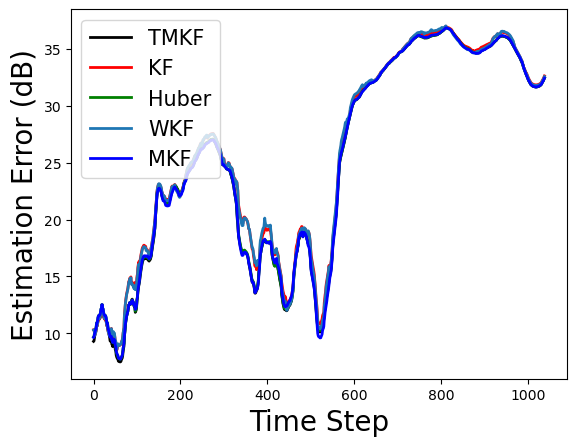

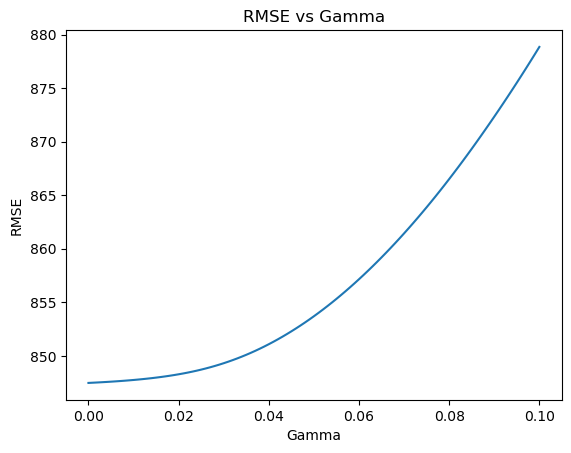

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.linalg import inv
import control


# Problem setting
sys = {
    'F': np.array([[0.9802, 0.0196], [0, 0.9802]]),
    'G': np.eye(2),
    'H': np.array([1, -1]),
    'D': 1,
    'Q': np.array([[1.9608, 0.0195], [0.0195, 1.9605]]),
    'R': 1
}
sys['R'] = np.array([[sys['R']]])
sys['D'] = np.array([[sys['D']]])
# Simulate 1000 steps, length of an episode
T = 1000

def smooth(x, window_len=11):
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    w = np.ones(window_len, 'd')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:-5]



# Init conditions
x_0 = np.random.randn(2, 1)
V_0 = np.eye(2)

# Parameters
is_time_variant = True
coeff_alpha = 0
epsilon = 0.05

# Simulate data
x, y, real_y, y0, real_F = generate_data(sys, x_0, T, coeff_alpha, epsilon, is_time_variant)

# TMKF: Optimal Kalman filter (i.e., KF with the true model)
x_0 = np.zeros(2)
import time
start_time = time.time()
xhat_TMKF, _ = TMKF(real_y, real_F, sys['G'], sys['H'], sys['Q'], sys['R'], V_0, x_0)
time_TMKF = (time.time() - start_time) / T
print(f'Avg Time of TMKF: {time_TMKF}')

err_TMKF = np.sum((x - xhat_TMKF) ** 2, axis=0)
RMSE_TMKF = np.sqrt(np.mean(err_TMKF))
print(f'---------------------RMSE of TMKF: {RMSE_TMKF}')

# KF: Standard Kalman filter
x_0 = np.zeros(2)
start_time = time.time()
xhat_KF, _  = KF(y, sys['F'], sys['G'], sys['H'], sys['Q'], sys['R'], V_0, x_0)
time_KF = (time.time() - start_time) / T
print(f'Avg Time of KF: {time_KF}')
err_KF = np.sum((x - xhat_KF) ** 2, axis=0)
RMSE_KF = np.sqrt(np.mean(err_KF))
print(f'---------------------RMSE of KF: {RMSE_KF}')

# Huber Kalman filter
x_0 = np.zeros(2)
k = 1.4
start_time = time.time()
xhat_Huber,_ = Huber(y, sys['F'], sys['G'], sys['H'], sys['Q'], sys['R'], V_0, x_0, k, epsilon)
time_Huber = (time.time() - start_time) / T
print(f'Avg Time of Huber: {time_Huber}')
err_Huber = np.sum((x - xhat_Huber) ** 2, axis=0)
RMSE_Huber = np.sqrt(np.mean(err_Huber))
print(f'---------------------RMSE of Huber: {RMSE_Huber}')

# tau filter
#tau = 0
    #c = 1.5e-4
    #y_delay = np.hstack((y0, y[:,0:-1])).reshape(-1, 1)
    #x_0 = np.zeros(2)
    #start_time = time.time()
    #xhat_tauKF,_,_,_,_ = tauKF(sys, c, tau, y_delay, x_0, V_0)
    #time_tauKF = (time.time() - start_time) / T
    #print(f'Avg Time of tauKF: {time_tauKF}')
    #err_tauKF = np.sum((x - xhat_tauKF.T) ** 2, axis=0)
    #RMSE_tauKF = np.sqrt(np.mean(err_tauKF))
    #print(f'---------------------RMSE of tauKF: {RMSE_tauKF}')

# Wasserstein filter
x_0 = np.zeros(2)
rho = 0.1
start_time = time.time()
xhat_WKF, V_WKF, G_WKF, S_WKF = WKF(sys, rho, y, x_0, V_0)
time_WKF = (time.time() - start_time) / T
print(f'Avg Time of WKF: {time_WKF}')
err_WKF = np.sum((x - xhat_WKF) ** 2, axis=0)
RMSE_WKF = np.sqrt(np.mean(err_WKF))
print(f'---------------------RMSE of WKF: {RMSE_WKF}')

# Moment filter
theta = 0.02
theta_1 = 1 - theta
theta_2 = 1 + theta
start_time = time.time()
xhat_MKF,_ = MKF(y, sys['F'], sys['G'], sys['H'], sys['Q'], sys['R'], V_0, x_0, k, epsilon, theta_2)
time_MKF = (time.time() - start_time) / T
print(f'Avg Time of Moment: {time_MKF}')
err_MKF = np.sum((x - xhat_MKF) ** 2, axis=0)
RMSE_MKF = np.sqrt(np.mean(err_MKF))
print(f'---------------------RMSE of MKF: {RMSE_MKF}')

# Plot results
plt.figure()
smt = 50
plt.plot(smooth(10 * np.log10(err_TMKF), smt), 'k', linewidth=2, label='TMKF')
plt.plot(smooth(10 * np.log10(err_KF), smt), 'r', linewidth=2, label='KF')
plt.plot(smooth(10 * np.log10(err_Huber), smt), 'g', linewidth=2, label='Huber')
#plt.plot(smooth(10 * np.log10(err_tauKF), smt), 'm', linewidth=2, label='$\\tau$-KF')
plt.plot(smooth(10 * np.log10(err_WKF), smt), linewidth=2, label='WKF')
plt.plot(smooth(10 * np.log10(err_MKF), smt), 'b', linewidth=2, label='MKF')

plt.xlabel('Time Step', fontsize=20)
plt.ylabel('Estimation Error (dB)', fontsize=20)
plt.legend(loc='upper left', fontsize=15)
plt.show()

# Assuming y, sys, V_0, x_0, x, and MKF function are defined elsewhere

expected_gamma = np.arange(0, 0.1 + 0.001, 0.001)
gamma_len = len(expected_gamma)
RMSE_array = np.zeros(gamma_len)

for gamma_index in range(gamma_len):
    gamma = expected_gamma[gamma_index]
    gamma_1 = 1 - gamma
    gamma_2 = 1 + gamma
    epsilon = 0.05
    k = 1.4  # use 1.4 or 2, make no big difference
    xhat_MKF,_ = MKF(y, sys['F'], sys['G'], sys['H'], sys['Q'], sys['R'], V_0, x_0, k, epsilon, gamma_2)
    err_MKF = np.sum((x - xhat_MKF)**2, axis=1)
    RMSE_MKF = np.sqrt(np.mean(err_MKF))
    RMSE_array[gamma_index] = RMSE_MKF

plt.plot(expected_gamma, RMSE_array)
plt.xlabel('Gamma')
plt.ylabel('RMSE')
plt.title('RMSE vs Gamma')
plt.show()